In [2]:
import sys
sys.path.insert(1, '/media/cinthia/Dados/Mestrado/mv-text-summarizer')

import glob, os
import pandas as pd
import json
import spacy
import nltk
import numpy as np
import json
import seaborn as sns
import pickle

from sumeval.metrics.rouge import RougeCalculator
from bs4 import BeautifulSoup
from pysbd.utils import PySBDFactory
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
import math


import keras
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, InputLayer
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split


from src import preprocess
from src import extract_features
from src import tokenizer
from src import create_features_df
from src import transform_data
from src import loader
from src import tunning_hyperparametrs as th
from src import utils
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import random


rouge = RougeCalculator(stopwords=True, lang="en")

#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('punkt')

#!python -m spacy download en_core_web_sm
nlp_sm = spacy.load('en_core_web_sm')

#!python -m spacy download en_core_web_md
nlp_md = spacy.load('en_core_web_md')

import warnings
warnings.filterwarnings("ignore")

# Introdução

Esse trabalho tem como objetivo explorar uma abordagem de sumarização extrativa de textos. A abordagem aqui utiliza modela o problema de sumarização de textos como um problema de regressão. A sumarização de textos tem como objetivo condensar as informações de um texto em um resumo simples e descritivo. Um dos benefícios da utilização dessa técnica é o de facilitar o acesso à informação, propiciando ao leitor uma visão geral dos textos sem a necessidade de analisar todo seu conteúdo. Com o aumento da quantidade de dados disponíveis nas bases digitais, a sumarização automática do conteúdo desses documentos torna-se cada vez mais importante. Contudo, gerar bons resumos é uma tarefa desafiante, pois envolve a compreensão da estrutura sintática e semântica do texto, a extração das informações mais relevantes e a elaboração de um resumo coerente e fluente. Compreendendo as dificuldades atreladas à tarefa e a sua importância nos dias atuais, o estudo e o desenvolvimento de modelos computacionais para sumarização automática de textos vem ganhando destaque. 

## Etapas Metodológicas

### Coleta  dos dados

---

A primeira etapa é a coleta dos documentos completos em formato XML. Ao todo, foram coletados xxx documentos. Após a coleta, os documentos são submetidos a uma etapa de preparação dos dados. Nessa etapa é realizada uma refatoração dos arquivos XML a fim de corrigir inconsistências para facilitar o processo de segmentação. Após, todos os documentos são segmentados em quatro seções e convertidos para o formato texto. Ao final, tem-se um conjunto de dados $D = \{D_{1}, D_{2}, ... D_{m}\}$, onde cada documento possui quatro seções $D_{m} = \{D_{m2}, D_{m3}, D_{m4}\}$. A seção $D_{m1}$ é o abstract do texto que é utilizado como ground-truth. Cada seção é composta por um conjunto de parágrafos $P$, onde $P = \{P_{1}, P_{2}, ... P_{j}\}$, e um conjunto de sentenças $S$, onde $S = \{S_{1}, S_{2}, ... S_{i}\}$. 


### Extração das Features

---

A terceira fase consiste na extração das features. Ao todo, foram extraídas 14 features, que são descritas a seguir.

Posição da sentença no texto: Considera que a posição da sentença no texto permite identificar a sua importância. De acordo com ... as sentenças que ocorrem no inicio e no final do texto tendem a ser mais importantes, pois, em geral, os textos possuem uma estrutura hierárquica que contribui para que essas informações sejam colocadas nessa posição. A Equação apresentada a seguir define o calculo do score das sentenças.

$SentPos(s_{i}) =$
$$
1,  se \ pos(S_{i}) \leq 3 \\
1 - \frac{i-3}{sent\_count(D_{m})}, se \ pos(S_{i}) > 3 
$$
    
onde, a $pos(S_{i})$ representa a posição da sentença $i$ no documento e $sent\_count(D_{m})$ representa a quantidade de sentenças no documento. 

Posição da sentença no parágrafo: De acordo com ..., a posição de uma sentença no parágrafo também é um indicativo de sua importância. Similar a feature de posição da sentença no texto, essa feature atribui uma importância para as sentenças considerando a sua posição no parágrafo. 

A Equação apresentada a seguir define o cálculo do score das sentenças.

$SentPos(s_{i}) =$
$$
        1,  se \ pos(S_{i}) \leq 1 \ or \  pos(S_{i}) == sent-count(P_{j})\\
        1 - \frac{i-2}{sent-count(P_{j})}, se \ pos(s_{i}) > 1 \ or \  pos(S_{i}) == sent-count(P_{j})
$$
    
onde, $P_{j}$ representa um parágrafo do texto e $s_{i}$ representa as sentenças do parágrafo, $pos(s_{i})$ representa a posição da sentença $i$ no parágrafo e $sent-count(P_{j})$ representa a quantidade de sentenças no parágrafo. 

Name Entity (NE): De acordo com ..., sentenças que se referem a pessoas, objetos, localização geográfica e tempo, por exemplo, podem conter mais informações importantes. Sendo assim, defini-se o $NE_{score}$ de uma sentença como:


$$NE_{score} = \frac{Count(NE_{(s_{i})})}{Max(Count(NE(D_{m}))},$$

onde, $NE$ retorna todas as name entity da sentença $i$ e $Count(NE(S_{i}))$ representa a quantidade de $NEs$ na sentença $i$, e $Max(Count(NE(D_{m})))$ representa o valor máximo de $NEs$ em uma sentença, considerando todas as sentenças do documento $D_{m}D$.

Part-Of-Speech (POS): ..., afirma que algumas classes de palavras desempenham um papel mais importante nas sentenças. De acordo com os autores, os substantivos e verbos são informações básicas de uma sentença. O substantivo pode desempenhar o papel de sujeito, objeto e complemento em uma sentença e o verbo permite identificar as orações das sentenças. Sendo assim, quanto maior a quantidade de substantivos e verbos em uma sentença, mais informações ela traz. Os autores definem o score das sentenças utilizando a equação $POS_{score}$ de uma sentença como:

$$POS_{score} = \frac{Count(POS_{(s_{i})})}{Max(Count(POS(D_{m}))},$$

onde, $POS$ retorna todos os substantivos e verbos da sentença. Nesse trabalho, o método $POS$ retorna também adjetivos e advérbios. $Count(POS(S_{i}))$ representa a quantidade de $POS$ na sentença $i$, e $Max(Count(POS(D_{m})))$ representa o valor máximo de $POS$ em uma sentença, considerando todas as sentenças do documento $D_{m}$.

- Palavras-chave: Essa feature ranqueia as sentenças de acordo com a quantidade de palavras-chave contidas nessa sentença. Para isso, são extraídos $x$ conjuntos de $k$ palavras-chave do texto considerando todas as sentenças. Cada conjunto é composto por n-grams com diferentes valores $n$ tal que, $n \in \{1, 2, 3\}$. Após, as sentenças são ponderas considerando a quantidade de n-grams que ocorre em cada sentença. Além das palavras-chave selecionadas por um algoritmo de extração de palavras-chaves, são utilizadas também as palavras-chaves definidas pelo autor do artigo. A hipótese testada é de que uma sentença que possui uma maior quantidade de palavras-chave é mais importante que uma sentença que possui poucas palavras chaves. 

$$ Keywords_{score} = CountMatch(Keywords(D_{m}, x), s_{i}), \forall i \in D_{m}$$

onde, $Keywords(D_{m}, x)$ retorna todas as palavras-chave do documento $D_{m}$, $CountMatch$ retorna a quantidade de palavras-chave na sentença $i$.

- Citação: Trabalhos como os de ..., afirmam que as citações representam um indicativo de embasamento das sentenças. Sendo assim, sentenças com uma maior quantidade de citação podem apresentar informações importantes. Essa feature, atribui um score para cada sentença baseado na quantidade de citações que ela possui. 

- Term Frequency - Inverse Sentence Frequency (TF-ISF): É uma medida estatística baseada no Term Frequency - Inverse Document Frequency (TF-IDF) que calcula a importância de uma palavra para um conjunto de sentenças. Para essa medida, quando uma palavra ocorre com frequência em uma sentença, o valor de TF-ISF aumenta proporcionalmente. No entanto, se essa palavra possui uma alta frequência em todas as sentenças, então o valor de TF-ISF dessa palavra diminuí. 

$$ TF-ISF (W, S) = TF(W, S) \times ISF(W),$$

$$ ISF(W) = \frac{log|S|}{SF(W)},$$

onde, $TF(W, S)$ representa a frequência da palavra $W$ na sentença $S$ e $ISF$ é a razão entre o $log$ da quantidade de sentenças pela frequência do termo $W$, representado por $SF(W)$. Para definir o valor de TF-ISF da sentença é calculada a média dos valores de TF-ISF das sentenças. 

- Centralidade: Essa feature pondera as sentenças de acordo com a sua representatividade semântica em relação a todas as outras sentenças de $D_{m}$. Inicialmente, todas as sentenças são representadas como vetores de embeddings. Após, todas as sentenças são agrupadas. O centroide de cada cluster é considerado a sentença que melhor representa, semanticamente, todas as outras sentenças do cluster. Após, é calculada a distância do cosseno entre cada sentença do cluster e seu centroid. A hipótese aqui é de que quanto mais próxima uma sentença é do centroid melhor ela representa todas as outras sentenças do cluster. Cada cluster representa um tópico e outliers possuem pesos de representatividade 0. O valor de score de cada sentença é definido utilizando as equações x, y:

$$ labels, centroid = Cluster(S),$$

$$ Centrality_{score} = cossine\_distance(label, centroid_{j})$$

onde, $Cluster(S)$ retorna o resultado da clusterização de todas as sentenças do texto, representado pela variável label, e o centroide de cada cluster. 

Tamanho da sentença: De acordo com ..., o tamanho da sentença é uma feature importante para o ranqueamento de sentenças. Sentenças curtas, em geral, não capturam todas as informações importantes do texto e sentenças muito longas tendem a conter informações muito específicas e/ou redundantes. A  Equação apresentada a seguir define o cálculo dessa feature.

$$ Len_{score}(S_{i}) = \frac{Len(S_{i})}{Max\_len(D_{m})}$$

onde, $Len(S_{i})$ retorna o tamanho da sentença $i$ e $Max\_len(D_{m})$ retorna o tamanho da maior sentença de $D_{m}$.

LexRank: É um algoritmo de sumarização baseado em grafo, onde os vértices representam as sentenças e as arestas representam a similaridade entre as sentenças. Basicamente, o algoritmo representa as sentenças como um vetor de TF-IDF e calcula a sentença centroide que é a média dos vetores encontra. Após, o algoritmo ranqueia as sentenças do texto com base na similaridade das sentenças com o centroide. Para calcular a similaridade, o algoritmo utiliza a similaridade do cosseno. A partir do grafo gerado, utiliza-se o algoritmo PageRank para ranquear as sentenças do texto.

TextRank: É um algoritmo de sumarização baseado em grafos, similar ao LexRank. A diferença entre o LexRank e o TextRank, é que o TextRank calcula a similaridade entre as sentenças utilizando uma medida de sobreposição de palavras, normalizada pelo tamanho da sentença.




## Preparação dos Dados

-----

A etapa de preparação dos dados envolveu a divisão do conjunto de dados em treino, teste e validação e a normalização dos dados. Além disso, foi realizado um trabalho árduo de experimentação até chegar a modelagem aqui apresentada. Inicialmente, o objetivo era trabalhar com um problema de classificação. Em geral, na literatura, os modelos de sumarização extrativa que utilizam aprendizado supervisionado modelam o problema de sumarização extrativa como um problema de classificação binária. Contudo, durantes os experimentos, foi encontrada uma grande dificuldade no ajuste dos modelos devido ao desbalanceamento dos dados. Sendo assim, a segunda alternativa foi a modelagem como um problema de regressão. Como o objetivo aqui é apenas identificar o melhor conjunto de sentenças para o resumo,  acredita-se que modelar o problema como um problema de regressão é um estratégia viável. 

O rótulo da sentença foi criado calculando o score de ROUGE-1 de cada sentença da seção $D_{mj}$, com todas as sentenças da seção $D_{m1}$. A seção $D_{m1}$, representa o abstract do documento, que foi escrito por um especialista, denominado aqui de resumo referência. Se o resumo referência possui 5 sentenças e a seção $D_{mj}$ possui 40 sentenças, esse processo irá gerar uma lista de com 40 itens onde cada item possui uma lista de com 5 valores de scores de ROUGE-1. Posteriormente, na segunda etapa, é utilizada a métrica Máximo, essa métrica define que o score das sentenças é o score máximo da sentença com todas as outras sentenças do resumo referência. Assim sendo, dado que $S_{1} \in D_{mj}$, então $score_{S_{1}} = max(\{score_{1}, ..., score_{5}\})$, onde $score_{1}$ representa o score entre $S_{1}$ e a primeira sentença do resumo referência. Esse processo tem como objetivo definir, para cada seção, um conjunto de scores para suas sentenças baseado na sua similaridade com o resumo referência.

Definir o rótulo também foi um grande desafio. O conjunto de métricas ROUGE é largamente utilizado na literatura para avaliar modelos de sumarização. As três principais métricas desse conjunto que são utilizadas na avaliação de resumos são as métricas ROUGE-1, ROUGE-2 e ROUGE-L. As métricas ROUGE-1 e ROUGE-2 avaliam as sentenças com base na sobreposição de n-grams de tamanho 1 e 2, respectivamente. A métrica ROUGE-L avalia as sentenças utilizando o conceito de Longest Common Substring (LCS). Essa métrica diz que quanto maior a sobreposição de LCS entre duas sentenças mais similares elas são.Inicialmente, os experimentos foram realizadas utilizando a métrica ROUGE-2 ao invés da métrica ROUGE-1, como apresentado anteriorme. Contudo, com a utilização da métrica ROUGE-2 a distribuição dos scores das sentenças eram valores muito baixos e, em sua maioria, zero. Nesse contexto, o ajuste dos modelos estava bastante complexo. Sendo assim, optou-se por utilizar a métrica ROUGE-1 que possui uma melhor distribuição de scores.

## Treinamento dos Algoritmos de Regressão

---

A quarta fase consiste no treinamento dos algoritmos de regressão. Foram testados os algoritmos 3 algoritmos: Random Forest (RF), Gradient Boosting (GB) e uma rede MultiLayer Perceptron (MLP). Cada algoritmo recebe como entrada a matriz de features e o conjunto de rótulos de cada seção. A matriz de features é normalizada usando o método StandartScale, disponível na biblioteca Scikit Learn. 

Para definir os hiperparâmetros dos modelos RF e GB, foi utilizado o k-fold cross-validation com k = 5. Para cada classificador são avaliados diferentes hiperparâmetros e os resultados obtidos são avaliados utilizando a métrica mean square error e mean absolute error. Todo esse processo foi realizado com auxílio do Randomized Search, disponível, também , na biblioteca Scikit Learn. Após esse processo, a base de dados é dividida em treinamento e teste e os hiperparâmetros obtidos são utilizado para treinar o modelo utilizando o conjunto de treino. Posteriormente, os resultados obtidos são avaliados na base de teste. Para a rede neural...

# Experimentos e Resultados

## Extração das Features

In [1]:
def extract_features_batches(batches, path_base, save_batches=500, verbose=True):

    all_scores_intro =[ ]
    all_features_intro = []
    all_scores_mat =[ ]
    all_features_mat = []
    all_scores_conc =[ ]
    all_features_conc = []

    files = []
    cont = 0
    count_texts = 0
    count_features = 0
  
    for batch in batches:

        if verbose:
            
            print("Batch: {} \n".format(cont))
    
        section_1, section_2, section_3, section_4, keywords = utils.load_batches(
            batch, path_base)

        if verbose:
            print("Iniciando a extração de features...")
            print("Total de arquivos: {} \n".format(len(section_1)))

        for i in range(len(section_1)):

            features_intro, scores_intro = extract_features_file(
                    section=section_2[i], reference=section_1[i], keywords=keywords[i],
                    number_text=count_texts, verbose=True)
            
            features_mat, scores_mat = extract_features_file(
                    section=section_3[i], reference=section_1[i], keywords=keywords[i],
                    number_text=count_texts, verbose=True)

            features_conc, scores_conc = extract_features_file(
                    section=section_4[i], reference=section_1[i], keywords=keywords[i],
                    number_text=count_texts, verbose=True)

            if not((features_intro.empty) or (scores_intro.empty)) and not((features_mat.empty) or (scores_mat.empty)) and not((features_conc.empty) or (scores_conc.empty)):

                if (features_intro.shape[0] == scores_intro.shape[0]) and (features_mat.shape[0] == scores_mat.shape[0]) and (features_conc.shape[0] == scores_conc.shape[0]):
                    
                    all_scores_intro.append(scores_intro)
                    all_features_intro.append(features_intro)

                    all_scores_mat.append(scores_mat)
                    all_features_mat.append(features_mat)
    
                    all_scores_conc.append(scores_conc)
                    all_features_conc.append(features_conc)

                    count_features+=1

            if (i % save_batches == 0) and (i !=0):
                print("Quantidade de arquivos processados: {}".format(count_features))
                print("Saving Results")

                utils.save_results(all_features_intro, all_scores_intro, number_text=count_texts,batch=cont, name_section='introduction', verbose=False)

                utils.save_results(all_features_mat, all_scores_mat, number_text=count_texts,batch=cont, name_section='materials', verbose=False)
                
                utils.save_results(all_features_conc, all_scores_conc, number_text=count_texts,batch=cont, name_section='conclusion', verbose=False)
                
                all_scores_intro =[]
                all_features_intro = []

                all_scores_mat =[ ]
                all_features_mat = []
    
                all_scores_conc =[ ]
                all_features_conc = []


            count_texts+=1
        
        cont+=1
    

In [3]:
def extract_features_file(section, reference, keywords, number_text, verbose=False):
  
  xml = preprocess.format_xml(str(section))
  text = preprocess.format_text(str(section), post_processing=False)
  reference = preprocess.format_text(str(reference), post_processing=True)


  bibs = extract_features.get_citations(xml)
  text = preprocess.replace_bib(text, bibs)
  text = preprocess.format_text(text, post_processing=True)

  soup = BeautifulSoup(text)
  text = soup.get_text()

  sentences = tokenizer.split_sentences([text])
  sentences = list(map(str, sentences[0]))
  sentences = preprocess.format_sentences(sentences)

  try:

    features = create_features_df.main(
    sentences, xml, keywords, nlp_sm, nlp_md)
    features_df = create_features_df.format_df (sentences, features)
    features_df['number_text'] = [number_text]*len(features_df)

    sentences_ref = tokenizer.split_sentences([reference])
    sentences_ref = list(map(str, sentences_ref[0]))

    scores_df, label = transform_data.main_create_label(sentences, sentences_ref, rouge)
    scores_df['label'] = label
    scores_df['number_text'] = [number_text]*len(scores_df)

    return features_df, scores_df

  except IndexError as error:
    return pd.DataFrame(), pd.DataFrame()
  except ValueError as error:
    return pd.DataFrame(), pd.DataFrame()

In [4]:
if os.path.isfile('batches.json'):

    print("Load Batch Files")
    with open('batches.json') as f:
        batches = json.load(f)

    batch_files = [value for key, value in batches.items()]
else: 

    print("Creating Batch Files")
    batch_files = utils.create_batches(path_base, tam=45)
    save_batches(batch_files)

Load Batch Files


Batch de teste é o 20!

In [37]:
path_base = "../../sumdata/dataset_articles"
batch_files = [[]]
extract_features_batches(batch_files, path_base, save_batches=1, verbose=True)

Batch: 5 

Iniciando a extração de features...
Total de arquivos: 1054 

Quantidade de arquivos processados: 308
Saving Results
501
Quantidade de arquivos processados: 619
Saving Results
1001
Batch: 6 

Iniciando a extração de features...
Total de arquivos: 1054 

Quantidade de arquivos processados: 976
Saving Results
1555
Quantidade de arquivos processados: 1297
Saving Results
2055
Batch: 7 

Iniciando a extração de features...
Total de arquivos: 1054 

Quantidade de arquivos processados: 1635
Saving Results
2609


## Algoritmos

In [4]:
def simple_nn(epochs=100, learning_rate=0.001):

    metrics = [
        keras.metrics.MeanSquaredError(name="mean_squared_error"),
        keras.metrics.MeanAbsoluteError(name="mean_absolute_error")]

    model = Sequential()
    model.add(InputLayer(input_shape=(14,)))
    model.add(Dense(128, activation='relu', kernel_initializer=keras.initializers.GlorotUniform()))
    model.add(Dropout(.3))
    model.add(Dense(256, activation='relu', kernel_initializer=keras.initializers.GlorotUniform()))
    model.add(Dropout(.3))
    model.add(Dense(256, activation='relu', kernel_initializer=keras.initializers.GlorotUniform()))
    model.add(Dropout(.3))
    model.add(Dense(256, activation='relu', kernel_initializer=keras.initializers.GlorotUniform()))
    model.add(Dropout(.3))
    model.add(Dense(256, activation='relu', kernel_initializer=keras.initializers.GlorotUniform()))
    model.add(Dropout(.3))
    model.add(Dense(256, activation='relu', kernel_initializer=keras.initializers.GlorotUniform()))
    model.add(Dropout(.3))
    model.add(Dense(256, activation='relu', kernel_initializer=keras.initializers.GlorotUniform()))
    model.add(Dropout(.3))
    model.add(Dense(128, activation='relu',kernel_initializer=keras.initializers.GlorotUniform()))
    model.add(Dropout(.3))
    model.add(Dense(1, activation='relu', kernel_initializer=keras.initializers.GlorotUniform()))


    model.compile(loss='mae', optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate, clipnorm=1.0), metrics=metrics)

    return model

In [5]:
def get_hiperparametrs_gb(X_train, y_train):

  parameters = {'n_estimators': [50, 100, 200],
               'min_samples_leaf':[5, 10, 20],
               'min_samples_split':[10, 20, 40],
               'max_depth':[5, 7, 20],
              }

  gbsearch = th.randomized_search (parameters, GradientBoostingRegressor(), X_train, y_train)

  return gbsearch

In [6]:
def get_hiperparametrs_rf(X_train, y_train):
  
  parameters = {'n_estimators': [50,  100, 200],
              'min_samples_leaf':[5, 10, 20],
              'min_samples_split':[10, 20, 40],
              'max_depth':[ 5, 7, 20]
              }

  rfsearch = th.randomized_search (parameters, RandomForestRegressor(), X_train, y_train)

  return rfsearch

In [7]:
def plot_history(history,dataset):

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Loos x Epoch - {}'.format(dataset))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    return plt

In [8]:
def pipeline_rf(dataset, X, y, X_train, y_train, X_test, y_test, train=False):

    if train == True:
        rfsearch = get_hiperparametrs_rf(X, y)
        pickle.dump(rfsearch, open('rfsearch_{}'.format(dataset), 'wb'))

        rf = RandomForestRegressor(
        n_estimators=rfsearch.best_estimator_.n_estimators,
        min_samples_leaf=rfsearch.best_estimator_.min_samples_leaf,
        min_samples_split=rfsearch.best_estimator_.min_samples_split,
        max_depth=rfsearch.best_estimator_.max_depth)
        rf.fit(X_train, y_train)
        pickle.dump(rf, open('rf_{}'.format(dataset), 'wb'))


    infile = open('rfsearch_{}'.format(dataset),'rb')
    rfsearch = pickle.load(infile)
    infile.close()

    print("\n Random Forest Hiperparâmetros")
    print("Num estimators: {}".format(rfsearch.best_estimator_.n_estimators))
    print("Min samples leaf: {}".format(rfsearch.best_estimator_.min_samples_leaf))
    print("Min samples splot: {}".format(rfsearch.best_estimator_.min_samples_split))
    print("Max depth: {}".format(rfsearch.best_estimator_.max_depth))
    print("Best Score: {}".format(rfsearch.best_score_))

    infile = open('rf_{}'.format(dataset),'rb')
    rf = pickle.load(infile)
    infile.close()

    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, mae

In [9]:
def pipeline_gb(dataset, X, y, X_train, y_train, X_test, y_test, train=False):

    if train:
        gbsearch = get_hiperparametrs_gb(X, y)
        pickle.dump(gbsearch, open('gbsearch_{}'.format(dataset), 'wb'))

        gb = GradientBoostingRegressor(
        n_estimators=gbsearch.best_estimator_.n_estimators, 
        min_samples_leaf=gbsearch.best_estimator_.min_samples_leaf, 
        min_samples_split=gbsearch.best_estimator_.min_samples_split, 
        max_depth=gbsearch.best_estimator_.max_depth)
        gb.fit(X_train, y_train)
        pickle.dump(gb, open('gb_{}'.format(dataset), 'wb'))

    infile = open('gbsearch_{}'.format(dataset),'rb')
    gbsearch = pickle.load(infile)
    infile.close()

    print("\n Gradient Boost Hiperparâmetros")
    print("Num estimators: {}".format(gbsearch.best_estimator_.n_estimators))
    print("Min samples leaf: {}".format(gbsearch.best_estimator_.min_samples_leaf))
    print("Min samples splot: {}".format(gbsearch.best_estimator_.min_samples_split))
    print("Max depth: {}".format(gbsearch.best_estimator_.max_depth))
    print("Best Score: {}".format(gbsearch.best_score_))

    infile = open('gb_{}'.format(dataset),'rb')
    gb = pickle.load(infile)
    infile.close()

    y_pred = gb.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, mae

In [10]:
def train_neural_model(dataset, X_train, y_train, validation_split=0.2, learning_rate=0.001, epochs=100, batch_size=64, verbose=0):

    model = simple_nn(epochs=1, learning_rate=learning_rate)

    def step_decay(epoch):
        initial_lrate = 0.001
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lrate

    lrate = LearningRateScheduler(step_decay)
    early = keras.callbacks.EarlyStopping(monitor='loss', patience=20)
    callbacks_list = [lrate, early]
    
    history = model.fit(
        X_train, y_train, validation_split=validation_split, epochs=epochs,
         batch_size=batch_size, verbose=verbose,  callbacks=callbacks_list)

    with open('/history_{}'.format(dataset), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    model_json = model.to_json()
    with open("model_{}.json".format(dataset), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model_{}.h5".format(dataset))
    print("Saved model to disk")


In [11]:
def pipeline_neural_model(
    dataset,  X_train, y_train, X_test, y_test, validation_split=0.2, learning_rate=0.001,
     epochs=100, batch_size=64, verbose=0, train=False):

    if train:
        train_neural_model(dataset, X_train, y_train, validation_split=validation_split, learning_rate=learning_rate,
         epochs=epochs, batch_size=batch_size, verbose=verbose)

    json_file = open('model_{}.json'.format(dataset), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights('model_{}.h5'.format(dataset))

    infile = open('history_{}'.format(dataset),'rb')
    history = pickle.load(infile)
    infile.close()

    y_pred = model.predict(X_test)

    plt = plot_history(history, dataset)
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, mae


## Preparação dos dados 

Número de arquivos de treino e validação: 3848

Número de arquivos de teste: 384

In [12]:
def len_sentences_by_text(df):
    
    grouped = df.groupby(['number_text'])
    tam = []
    num = []

    for name, group in grouped:
        if len(group) >= 10 and len(group) <= 40:
            num.append(name)
            tam.append(len(group))

    return tam

In [13]:
def  load_preparation(X, y, dataset, train=False):

    columns_name = ['text_rank', 'lex_rank', 'count_one_gram', 'count_two_gram',
        'count_three_gram', 'count_article_keywords', 'tf-isf',
        'position_score', 'paragraph_score', 'number_citations', 'length_score',
        'pos_score', 'ner_score', 'dist_centroid']

    X = X[columns_name]
    y = y['rouge_1'] *100

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=47)

    print("\n{} - Tamanho da amostra de treino: {}".format(dataset, len(X_train)))
    print("{} - Tamanho da amostra de test: {}".format(dataset, len(X_test)))

    if train:
        scaler = StandardScaler()
        scaler.fit(X_train)
        pickle.dump(scaler, open('StandardScaler_{}', 'wb'))
    else:
        infile = open('StandardScaler_{}'.format(dataset),'rb')
        scaler = pickle.load(infile)
        infile.close()

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X, y, X_train, X_test, y_train, y_test

In [14]:
def main(dataset, train=False): 

    features_df = loader.read_features(path="../result/{}/features_*.csv".format(dataset))
    scores_df = loader.read_features(path="../result/{}/scores_*.csv".format(dataset))

    print("Shape features para a {} - {}".format(dataset, features_df.shape))
    print("Shape features para a {} - {}".format(dataset, scores_df.shape))

    X, y, X_train, X_test, y_train, y_test = load_preparation(features_df, scores_df, dataset)

    result = pd.DataFrame({'gb':[], 'rf':[], 'mlp':[]})

    mse, mae = pipeline_gb(dataset, X, y, X_train, y_train, X_test, y_test, train=train)
    result['gb'] = [mse, mae]
    mse, mae = pipeline_rf(dataset, X, y, X_train, y_train, X_test, y_test, train=train)
    result['rf'] = [mse, mae]
    mse, mae = pipeline_neural_model(
        dataset,  X_train, y_train, X_test, y_test, validation_split=0.2, learning_rate=0.001,
        epochs=100, batch_size=64, verbose=0, train=train)
    result['mlp'] = [mse, mae]

    return features_df, scores_df, X_train, X_test, y_train, y_test, result

# Avaliação dos resultados por seção

São treinados diferentes algoritmos para cada uma das seções dos documentos, são gerados resumos para cada seção selecionando as sentenças com os 3 melhores scores. São avaliados os resultados de cada seção separadamente e os resumos gerados pela combinação dos resumos de cada seção. 

A busca de hiperparâmetros é realizada com todo dataset. 
Para normalizar os dados eu utilizo o StandartScale.

A seguir é apresentado para cada seção o shape das features e scores, o tamanho da base de treino e teste, os hiperparâmetros obtidos com o RandomizedSearch e o bestscore que é a estimativa do erro esperado.

## Introdução

In [36]:
path_base = "../../sumdata/dataset_articles"

Shape features para a introduction - (76938, 16)
Shape features para a introduction - (76938, 5)

introduction - Tamanho da amostra de treino: 61550
introduction - Tamanho da amostra de test: 15388

 Gradient Boost Hiperparâmetros
Num estimators: 200
Min samples leaf: 10
Min samples splot: 20
Max depth: 5
Best Score: 0.2552171838114866

 Random Forest Hiperparâmetros
Num estimators: 50
Min samples leaf: 20
Min samples splot: 40
Max depth: 7
Best Score: 0.024119128157676584


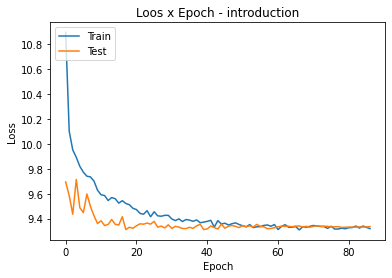

In [37]:
dataset='introduction'
features_intro, scores_intro, X_train, X_test, y_train, y_test, result_intro = main(dataset, train=False)

## Materials and Methods

Shape features para a materials - (172234, 16)
Shape features para a materials - (172234, 5)

materials - Tamanho da amostra de treino: 137787
materials - Tamanho da amostra de test: 34447

 Gradient Boost Hiperparâmetros
Num estimators: 50
Min samples leaf: 10
Min samples splot: 20
Max depth: 5
Best Score: 0.009325638415237725

 Random Forest Hiperparâmetros
Num estimators: 100
Min samples leaf: 20
Min samples splot: 40
Max depth: 7
Best Score: 0.008664772857182302


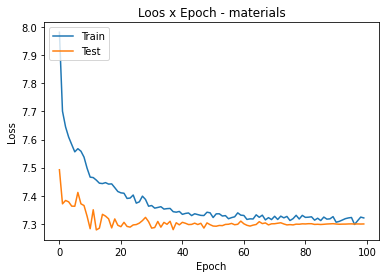

In [38]:
dataset='materials'
features_mat, scores_mat, X_train, X_test, y_train, y_test, result_mat = main(dataset, train=False)

## Conclusion

Shape features para a conclusion - (297889, 16)
Shape features para a conclusion - (297889, 5)

conclusion - Tamanho da amostra de treino: 238311
conclusion - Tamanho da amostra de test: 59578

 Gradient Boost Hiperparâmetros
Num estimators: 200
Min samples leaf: 10
Min samples splot: 20
Max depth: 5
Best Score: 0.2552171838114866

 Random Forest Hiperparâmetros
Num estimators: 200
Min samples leaf: 20
Min samples splot: 40
Max depth: 7
Best Score: 0.2191141161210636


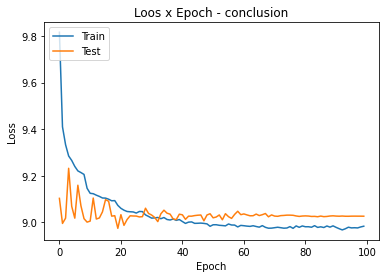

In [39]:
dataset='conclusion'
features_conc, scores_conc, X_train, X_test, y_train, y_test, result_conc = main(dataset, train=False)

## Resultados da Avaliação dos modelos na base de teste

Cada algoritmo é treinado com o conjunto de hiperparâmetros obtidos anteriormente na base de treino e os resultados na base de teste são apresentados nas tabelas abaixo.

É possível ver que a rede MLP e o GB apresentam resultados superiores aos do RF e similares entre si. Esse comportamente se mantém nos testes de sumarização que são apresentados na próxima seção.

Linha 0 - MAE

Linha 1 - MSE

In [40]:
result_intro

,gb,rf,mlp
0,163.947292,173.243343,167.101167
1,9.447179,9.781518,9.250687


In [41]:
result_mat

,gb,rf,mlp
0,118.328920,121.440611,129.537783
1,7.554799,7.652398,7.323716


In [42]:
result_conc

,gb,rf,mlp
0,163.125807,171.181866,172.586313
1,9.081223,9.327374,9.056795


## Avaliação da Tarefa de Sumarização

Os dados aqui apresentados são relativos a tarefa de sumarização, os testes foram feitos em 71 arquivos selecionados aleatoriamente e esses arquivos não fazem parte da base de treino e teste. Todos or arquivos estão completos e a sumarização é realizada para cada um, separadamente.  

Para avaliar os modelos são utilizadas as métricas ROUGE-1, ROUGE-2 e ROUGE-L. 

### Suppress code

In [43]:
def create_label(df):

    label = [0 for i in range(len(df))]

    j = 0
    for index, row in df.sort_values('predictions', ascending=False).iterrows():
      label[index] = 1
      j +=1

      if j==3:
        break

    return label

In [44]:
def summarize(X_val, y_val, scaler, model):

        columns_name = ['text_rank', 'lex_rank', 'count_one_gram', 'count_two_gram',
                'count_three_gram', 'count_article_keywords', 'tf-isf',
                'position_score', 'paragraph_score', 'number_citations', 'length_score',
                'pos_score', 'ner_score', 'dist_centroid']

        #sum_x_test = X_val.loc[X_val['number_text'] == n]
        try:
                sentences = X_val[0]
        except KeyError:
                sentences = X_val['0']
                
        sum_x_test = X_val[columns_name]
        sum_y_test = y_val['rouge_1']*100

        sum_x_test = scaler.transform(sum_x_test)
        y_pred = model.predict(sum_x_test)

        summ_df = pd.DataFrame({'sentences': sentences, 'predictions': y_pred.reshape(1, -1)[0]})
        summ_df.reset_index(inplace=True, drop=True)
        summ_df['label'] = create_label(summ_df)
        summary = ' '.join(summ_df.loc[summ_df['label'] == 1]['sentences'].values)

        return summ_df, summary

In [45]:
import re

def get_ref_summary(file_name):

    text = loader.load_files(path_base, [file_name])
    reference = preprocess.format_xml(text[0].get('sec_abstract'))
    reference = re.sub('(?<=<title>)(.*?)(?=</title>)', '', reference)
    reference = re.sub(r'[\t\n\r]', '', reference)
    reference = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", reference)
    reference = preprocess.xml_to_text(reference)
    reference = preprocess.format_text(str(reference), post_processing=True)
    reference = re.sub(r' +', " ", reference)
    reference = reference.strip()
    
    return reference

In [46]:
def evaluate_summaries(candidate, reference):

    rouge_1 = rouge.rouge_n(summary=candidate, references=reference, n=1)
    rouge_2 = rouge.rouge_n(summary=candidate, references=reference, n=2)
    rouge_l = rouge.rouge_l(summary=candidate, references=reference)

    return [rouge_1, rouge_2, rouge_l]

In [47]:
def load_summarize_models(model, dataset):

    if model == 'mlp':
        json_file = open('model_{}.json'.format(dataset), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.load_weights('model_{}.h5'.format(dataset))
    else: 
        infile = open('{}_{}'.format(model, dataset),'rb')
        model = pickle.load(infile)
        infile.close()

    infile = open('StandardScaler_{}'.format(dataset),'rb')
    scaler = pickle.load(infile)
    infile.close()
    
    return model, scaler

In [48]:
def summarizer_all_texts(model_intro, scaler_intro, model_mat, scaler_mat, model_conc, scaler_conc, path):

    summaries_intro = []
    summaries_mat = []
    summaries_conc = []
    summaries_merged = []
    references = []

    files = glob.glob(path)
    files = [i.split("/")[-1] for i in files]

    for file in files:

        name = file.split('_')[1]

        X_intro = pd.read_csv("../sumdata/{}/{}".format('introduction', file))
        y_intro =  pd.read_csv("../sumdata/{}/scores_{}".format('introduction', name))

        X_mat = pd.read_csv("../sumdata/{}/{}".format('materials', file))
        y_mat =  pd.read_csv("../sumdata/{}/scores_{}".format('materials', name))

        X_conc = pd.read_csv("../sumdata/{}/{}".format('conclusion', file))
        y_conc =  pd.read_csv("../sumdata/{}/scores_{}".format('conclusion', name))

        _, summary_intro = summarize(X_intro, y_intro, scaler_intro, model_intro)
        _, summary_mat = summarize(X_mat, y_mat, scaler_mat, model_mat)
        _, summary_conc = summarize(X_conc, y_conc, scaler_conc, model_conc)
        merged = summary_intro + " " + summary_mat + " " + summary_conc

        summaries_intro.append(summary_intro)
        summaries_mat.append(summary_mat)
        summaries_conc.append(summary_conc)
        summaries_merged.append(merged)

        name_articles = name.replace(".csv", ".json")

        references.append(get_ref_summary(name_articles))


    names = [i.split('_')[1].replace(".csv", "") for i in files]
    summaries = pd.DataFrame({"article": names, "reference": references, "intro": summaries_intro, "mat": summaries_mat,"conc": summaries_conc,"merged": summaries_merged})

    return summaries

In [49]:
  def evaluation_all_summaries(summaries):

    all_scores = []
    i = 0
    for index, row in summaries.iterrows():

        scores_intro = evaluate_summaries(row['intro'], row['reference'])
        scores_mat = evaluate_summaries(row['mat'], row['reference'])
        scores_conc = evaluate_summaries(row['conc'], row['reference'])
        scores_merged = evaluate_summaries(row['merged'], row['reference'])

        scores = pd.DataFrame({
                            "article": row['article'],
                            "intro_r1": scores_intro[0],
                            "intro_r2": scores_intro[1], 
                            "intro_r3": scores_intro[2],  
                            "mat_r1": scores_mat[0],
                            "mat_r2": scores_mat[1],
                            "mat_rl": scores_mat[2],
                            "conc_r1": scores_conc[0],
                            "conc_r2": scores_conc[1],
                            "conc_rl": scores_conc[2],
                            "merged_r1": scores_merged[0],
                            "merged_r2": scores_merged[1],
                            "merged_rl": scores_merged[2]},  index=[i])

        i+=1

        all_scores.append(scores)

    df = pd.concat(all_scores)

    return df

### Resultados

In [50]:
mlp_model_intro, scaler_intro = load_summarize_models(model='mlp', dataset='introduction')
mlp_model_mat, scaler_mat = load_summarize_models(model='mlp', dataset='materials')
mlp_model_conc, scaler_conc = load_summarize_models(model='mlp', dataset='conclusion')

path = "../sumdata/introduction/features_*"
summaries_mlp = summarizer_all_texts(mlp_model_intro, scaler_intro, mlp_model_mat, scaler_mat, mlp_model_conc, scaler_conc, path)
summaries_mlp.to_csv("summaries_mlp.csv", index = False)
scores_mlp = evaluation_all_summaries(summaries_mlp)

In [51]:
gb_model_intro, _ = load_summarize_models(model='gb', dataset='introduction')
gb_model_mat, _ = load_summarize_models(model='gb', dataset='materials')
gb_model_conc, _ = load_summarize_models(model='gb', dataset='conclusion')

path = "../sumdata/introduction/features_*"
summaries_gb = summarizer_all_texts(gb_model_intro, scaler_intro, gb_model_mat, scaler_mat, gb_model_conc, scaler_conc, path)
summaries_gb.to_csv("summaries_gb.csv", index = False)
scores_gb = evaluation_all_summaries(summaries_gb)

In [52]:
rf_model_intro, _ = load_summarize_models(model='rf', dataset='introduction')
rf_model_mat, _ = load_summarize_models(model='rf', dataset='materials')
rf_model_conc, _ = load_summarize_models(model='rf', dataset='conclusion')

path = "../sumdata/introduction/features_*"
summaries_rf = summarizer_all_texts(rf_model_intro, scaler_intro, rf_model_mat, scaler_mat, rf_model_conc, scaler_conc, path)
summaries_rf.to_csv("summaries_rf.csv", index = False)
scores_rf = evaluation_all_summaries(summaries_rf)

In [53]:
scores_mlp.describe().T

,count,mean,std,min,25%,50%,75%,max
intro_r1,71.0,0.284745,0.092789,0.083770,0.216374,0.294118,0.357375,0.500000
intro_r2,71.0,0.108754,0.079902,0.000000,0.054670,0.091324,0.144107,0.430769
intro_r3,71.0,0.183563,0.072115,0.041885,0.133894,0.173469,0.218081,0.469697
mat_r1,71.0,0.141949,0.078060,0.000000,0.086800,0.120482,0.184820,0.364372
mat_r2,71.0,0.041478,0.050602,0.000000,0.010211,0.024691,0.055972,0.233333
mat_rl,71.0,0.097280,0.056947,0.000000,0.058968,0.090000,0.129454,0.299595
conc_r1,71.0,0.257959,0.070991,0.071006,0.216448,0.255319,0.314650,0.406504
conc_r2,71.0,0.089224,0.051907,0.000000,0.046465,0.083721,0.131373,0.185792
conc_rl,71.0,0.167098,0.047582,0.047337,0.136054,0.163743,0.205670,0.278607
merged_r1,71.0,0.367071,0.076714,0.226721,0.312228,0.367647,0.423158,0.544850


In [54]:
scores_gb.describe().T

,count,mean,std,min,25%,50%,75%,max
intro_r1,71.0,0.288521,0.089273,0.115942,0.222813,0.287234,0.354921,0.528571
intro_r2,71.0,0.110267,0.075131,0.000000,0.050651,0.101266,0.147990,0.420290
intro_r3,71.0,0.187197,0.074604,0.072464,0.131602,0.186667,0.219219,0.514286
mat_r1,71.0,0.139153,0.071048,0.000000,0.093455,0.125786,0.167015,0.364372
mat_r2,71.0,0.040277,0.049092,0.000000,0.010211,0.024845,0.052185,0.242424
mat_rl,71.0,0.095860,0.056819,0.000000,0.061576,0.082474,0.113402,0.300429
conc_r1,71.0,0.258114,0.070387,0.083333,0.208825,0.259414,0.306164,0.435644
conc_r2,71.0,0.087115,0.050833,0.000000,0.044806,0.083721,0.124578,0.241206
conc_rl,71.0,0.171213,0.051194,0.070175,0.134961,0.167401,0.206897,0.308458
merged_r1,71.0,0.367378,0.084124,0.193548,0.305329,0.379447,0.427123,0.555556


In [55]:
scores_rf.describe().T

,count,mean,std,min,25%,50%,75%,max
intro_r1,71.0,0.283802,0.084546,0.115942,0.222222,0.275000,0.346786,0.528571
intro_r2,71.0,0.110161,0.072852,0.000000,0.064161,0.100000,0.137533,0.420290
intro_r3,71.0,0.187552,0.070517,0.072464,0.137934,0.181034,0.219092,0.514286
mat_r1,71.0,0.134302,0.070506,0.000000,0.088254,0.133333,0.168182,0.321951
mat_r2,71.0,0.037262,0.044938,0.000000,0.007766,0.025641,0.048812,0.232759
mat_rl,71.0,0.092474,0.051349,0.000000,0.054487,0.086957,0.113402,0.271186
conc_r1,71.0,0.251143,0.075040,0.094737,0.200000,0.247934,0.306592,0.477064
conc_r2,71.0,0.087336,0.055779,0.000000,0.047603,0.084848,0.116212,0.251429
conc_rl,71.0,0.163517,0.057974,0.063158,0.120798,0.155689,0.195033,0.305085
merged_r1,71.0,0.354518,0.084451,0.151351,0.290412,0.359551,0.424450,0.541254


# Exemplos de resumos gerados

In [ ]:
summaries_mlp =pd.read_csv("summaries_mlp.csv")

In [63]:
n = 30

In [64]:
#Ground Truth
summaries_mlp['reference'][n]

'The present research examined developmental and gender differences in the relative accessibility of different gender stereotype domains. A Northeastern US sample of children ages to years old provided open ended descriptions of girls and boys. Responses were coded by domain to examine differences by grade, gender of participant, and gender of target. Analyses revealed that girls and older children provided a higher proportion of stereotypes, and that appearance stereotypes were particularly prevalent in descriptions of girls and activity/trait stereotypes were more prevalent in descriptions of boys. Results are discussed in terms of implications for research on the stereotype knowledgebehavior link and the need for more attention to the role of appearance stereotypes in the gender stereotype literature.'

In [65]:
summaries_mlp['intro'][n]

'To the best of our knowledge, no study to date has examined accessibility differences of gender stereotype domains in young children. Children’s gender concepts may be similarly differentiated in structure, which could have important implications for how we understand gender stereotype development in children . Therefore, boys may endorse stronger gender stereotypical preferences than girls, but only in the domain of activities and toys.'

In [66]:
summaries_mlp['mat'][n]

'Prior research on gender stereotype domains guided the development of the coding scheme that was used to categorize children’s responses. For the present study, children’s responses were coded into general categories based on their stereotyped nature and into sub categories based on their domains. These domain specific proportions were calculated by dividing the number of stereotyped responses for a given domain divided by the total number of statements .'

In [62]:
summaries_mlp['conc'][0]

'We conclude that the specific movement of grk RNA particles in the nurse cells along straight paths to the ring canals is MT dependent . We conclude that the transport of grk RNA within the nurse cells towards ring canals and from the nurse cell to the oocyte is Dynein dependent . Within nurse cells, we have identified a new path of Dynein dependent transport to the ring canals that link the nurse cells to the oocyte.'

# Conclusão 

O maior desafio encontrado na etapa de treinamento foi o ajuste da rede MLP. Inicialmente, foi utilizada uma arquitetura apenas com duas camadas. Quando o treinamento era realizado por poucas epócas o modelo não convergia e todas as predições era a média de todos os valores. Quando realizava o treinamento por muitas epócas (+ 500) o modelo convergia na base de treino porém não generalizava, ou seja, ele só decorava os dados de treino. Posteriormente, eu utilizei a técnica Dropout com intuito evitar overfitting. A partir desse momento o modelo não sofria overfitting, mas também não aprendia. Diante disso, foram feitos diversos ajustes a fim de obter um melhor resultado sem gerar overfitting, como: 

- Número de camadas da rede;
- Número de neurônios nas camadas
- Alterar o otimizador utilizado;
- Alterar função de ativação;
- Regular taxa de aprendizagem;
- Alterar o modo de inicialização dos pesos;
- Remover features;
- Ajuste do Dropout;
- Alterar número o tamanho dos batches;
- Alterar função de perda;
- Adicionar o clip;
- Adicionar um Learning Rate Scheduler;
- Adicionar EarlyStopping.

Dentre todos esses ajustes, os que fizeram maior diferença o aumento da complexidade do modelo juntamente com o Dropout. Desde o incío eu utilizei o Adam Optimizer e acabei voltando pra ele, isso também ocorreu para as funções de ativação eu comecei utilizando relu e acabei voltando pra ela. A melhor estratégia que eu encontrei pra ajustar a taxa de aprendizagem foi a utilização do Learning Rate Scheduler. Ao iniciar o treinamento, a função de perda diminuia e o erro na validação também diminuia, contudo, no decorrer do processo de aprendizagem começava a aumentar. Nesse momente, eu adicionei o Early Stopping porém mesmo com um patience=20, o treinamento parava precocemente e muitas vezes com um erro alto. Sendo assim, eu adicionei o Learning Rate Scheduler como uma tentativa de realizar um ajuste fino no final e tentar previnir a parada precoce com um erro alto. Outro ajuste realizado que ajudou a melhorar o desempenho foi a alteração do modo de inicialização dos pesos. Com a configuração default, a maioria das predições eram o mesmo valor sendo esse aproximadamente a média para todas as predições. Esse predição possui um erro baixo, porém não é util. Para evitar isso, foi alterado o kernel de inicialização de Normal para GlorotUniform. A diferença nos resultados foi muito grande. Antes desse ajuste a maioria das predições era o valor médio e alguns possuiam variações muito pequenas. Com a mudança do kernel já é possível ver um mudança muito mais significativa no valor das predições. Os resultados obtidos estão longe do que considero satisfatório, contudo eu acredito que há diversos outros ajustes que podem ser realizados para gerar melhores resultados.

Além disso, foi possível ver uma superioridade nos resultados obtidos com a rede MLP e com GB em relação ao RF. A rede MLP e o GB apresentaram uma diferença muito pequena tanto na avaliação do modelos com as métricas MAE e MSE quanto na avaliação do desempenho do modelo na tarefa de sumarização.